## Introduction to basic RL algorithms

### MAB and simple bandit algorithms
* Based on [this github repo](https://github.com/yfletberliac/rlss-2019/tree/master)

In [1]:
# Initialize the helper class for each type of bandit

import numpy as np
import random 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(50)
random.seed(50)

class Bernoulli:
    def __init__(self, p):
        # create a Bernoulli arm with mean p
        self.mean = p
        self.variance = p * (1 - p)

    def sample(self):
        # generate a reward from a Bernoulli arm
        return float(random.random() < self.mean)


class Gaussian:
    def __init__(self, mu, var=0.1):
        # create a Gaussian arm with specified mean and variance
        self.mean = mu
        self.variance = var

    def sample(self):
        # generate a reward from a Gaussian arm
        return self.mean + sqrt(self.variance) * np.random.normal()

In [2]:
bern_0p1 = Bernoulli(0.1)
for i in range(10):
    print(bern_0p1.sample())

0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0


In [3]:
gauss_0_5 = Gaussian(0.5, 0.1)
for i in range(10):
    print(gauss_0_5.sample())

0.0065733384713062
0.490204021656954
0.30364519165992343
0.036858985012838796
0.9464965678288007
0.34924405927954894
0.253193964044545
0.8384483749252325
0.09450347702192607
0.08021431269336687


In [4]:
# helper functions for MAB
class MAB:
    def __init__(self, arms):
        """given a list of arms, create the MAB environnement"""
        self.arms = arms
        self.nbArms = len(arms)
        self.means = [arm.mean for arm in arms]
        self.bestarm = np.argmax(self.means)

    def generateReward(self, arm):
        return self.arms[arm].sample()


## some functions that create specific MABs


def BernoulliBandit(means):
    """define a Bernoulli MAB from a vector of means"""
    return MAB([Bernoulli(p) for p in means])


def GaussianBandit(means, var=0.1):
    """define a Gaussian MAB from a vector of means"""
    return MAB([Gaussian(mu, var) for mu in means])

In [5]:
means = [0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.6, 0.7, 0.9]

In [6]:
BernBandits = BernoulliBandit(means)

In [7]:
for i in range(10):
    print(BernBandits.generateReward(1))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [8]:
GaussBandits = GaussianBandit(means)

In [9]:
for i in range(10):
    print(GaussBandits.generateReward(1))

0.13995146953058055
0.37264959251183993
0.32032757359853403
-0.005798801006472759
-0.21544543885258313
0.6056191978441084
1.1480026429227654
0.4123604462306384
0.13916994989215808
0.33488936544438186


In [10]:
# Uniform exploration


class UE_Bandit:
    def __init__(self, nbArms):
        self.nbArms = nbArms  # number of arms
        self.actions = np.zeros(nbArms)  # number of times each arm was pulled
        self.reward = np.zeros(nbArms)  # total reward for each arm
        self.avg_reward = np.zeros(nbArms)  # average reward for each arm

    def select_action(self):
        # Uniform exploration phase
        if np.min(self.actions) == 0:
            return np.argmin(self.actions)
        # Exploitation phase
        else:
            return np.argmax(self.avg_reward)

    def update(self, action, reward):
        self.actions[action] += 1
        self.reward[action] += reward
        self.avg_reward[action] = self.reward[action] / self.actions[action]


# Greedy


class GreedyBandit:
    def __init__(self, nbArms):
        self.nbArms = nbArms  # number of arms
        self.actions = np.zeros(nbArms)  # number of times each arm was pulled
        self.reward = np.zeros(nbArms)  # total reward for each arm
        self.avg_reward = np.zeros(nbArms)  # average reward for each arm

    def select_action(self):
        # Always select the action with the highest average reward
        return np.argmax(self.avg_reward)

    def update(self, action, reward):
        self.actions[action] += 1
        self.reward[action] += reward
        self.avg_reward[action] = self.reward[action] / self.actions[action]


# Epsilon-Greedy


class EpsilonGreedyBandit:
    def __init__(self, nbArms, epsilon):
        self.nbArms = nbArms  # number of arms
        self.epsilon = epsilon  # probability of exploration
        self.actions = np.zeros(nbArms)  # number of times each arm was pulled
        self.reward = np.zeros(nbArms)  # total reward for each arm
        self.avg_reward = np.zeros(nbArms)  # average reward for each arm

    def select_action(self):
        # With probability epsilon, explore randomly
        if random.random() < self.epsilon:
            return np.random.randint(0, self.nbArms)
        # Otherwise, exploit
        else:
            return np.argmax(self.avg_reward)

    def update(self, action, reward):
        self.actions[action] += 1
        self.reward[action] += reward
        self.avg_reward[action] = self.reward[action] / self.actions[action]

In [11]:
# experiments
def experiment(bandit, algorithm, N):
    # initialize the history
    reward_history = np.zeros(N)
    action_history = np.zeros(N)
    # loop over N rounds
    for t in range(N):
        # select an action
        action = bandit.select_action()
        # generate a reward
        reward = algorithm.generateReward(action)
        # update the history
        reward_history[t] = reward
        action_history[t] = action
        # update the bandit
        bandit.update(action, reward)
    return reward_history, action_history

In [12]:
ue_r_history, ue_a_history = experiment(
    UE_Bandit(BernBandits.nbArms), BernBandits, 1000
)
gr_r_history, gr_a_history = experiment(
    GreedyBandit(BernBandits.nbArms), BernBandits, 1000
)
eg_r_history, eg_a_history = experiment(
    EpsilonGreedyBandit(BernBandits.nbArms, 0.1), BernBandits, 1000
)

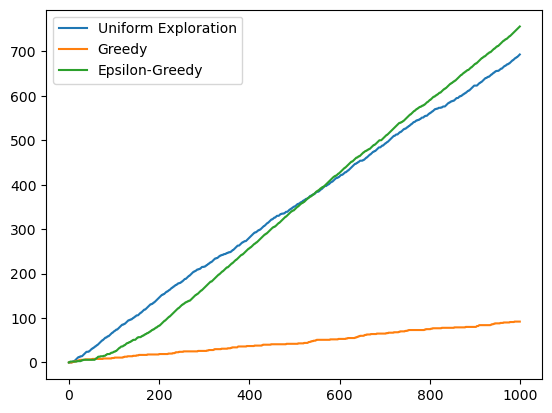

In [13]:
plt.plot(np.cumsum(ue_r_history), label="Uniform Exploration")
plt.plot(np.cumsum(gr_r_history), label="Greedy")
plt.plot(np.cumsum(eg_r_history), label="Epsilon-Greedy")
plt.legend()

In [14]:
ue_r_gauss_history, ue_a_gauss_history = experiment(
    UE_Bandit(GaussBandits.nbArms), GaussBandits, 1000
)
gr_r_gauss_history, gr_a_gauss_history = experiment(
    GreedyBandit(GaussBandits.nbArms), GaussBandits, 1000
)
eg_r_gauss_history, eg_a_gauss_history = experiment(
    EpsilonGreedyBandit(GaussBandits.nbArms, 0.1), GaussBandits, 1000
)

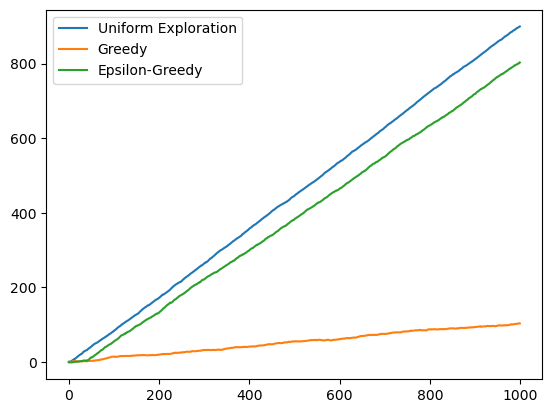

In [15]:
plt.plot(np.cumsum(ue_r_gauss_history), label="Uniform Exploration")
plt.plot(np.cumsum(gr_r_gauss_history), label="Greedy")
plt.plot(np.cumsum(eg_r_gauss_history), label="Epsilon-Greedy")
plt.legend()

In [16]:
means_large = np.random.rand(500)
means_gauss_large = np.random.normal(2.0, 0.5, 500)
BernBandits_large = BernoulliBandit(means_large)
GaussBandits_large = GaussianBandit(means_gauss_large)

In [17]:
ue_r_history, ue_a_history = experiment(
    UE_Bandit(BernBandits_large.nbArms), BernBandits_large, 1000
)
gr_r_history, gr_a_history = experiment(
    GreedyBandit(BernBandits_large.nbArms), BernBandits_large, 1000
)
eg_r_history, eg_a_history = experiment(
    EpsilonGreedyBandit(BernBandits_large.nbArms, 0.1), BernBandits_large, 1000
)

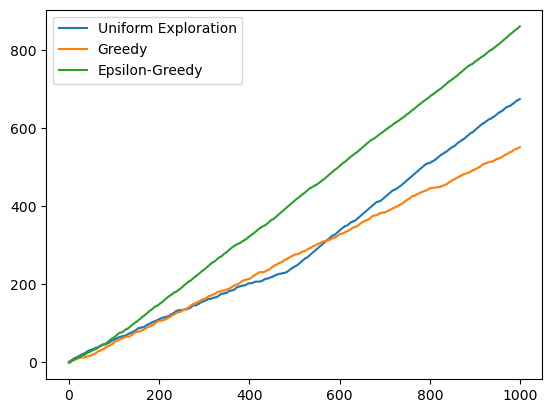

In [18]:
plt.plot(np.cumsum(ue_r_history), label="Uniform Exploration")
plt.plot(np.cumsum(gr_r_history), label="Greedy")
plt.plot(np.cumsum(eg_r_history), label="Epsilon-Greedy")
plt.legend()

In [19]:
ue_r_gauss_history, ue_a_gauss_history = experiment(
    UE_Bandit(GaussBandits_large.nbArms), GaussBandits_large, 1000
)
gr_r_gauss_history, gr_a_gauss_history = experiment(
    GreedyBandit(GaussBandits_large.nbArms), GaussBandits_large, 1000
)
eg_r_gauss_history, eg_a_gauss_history = experiment(
    EpsilonGreedyBandit(GaussBandits_large.nbArms, 0.1), GaussBandits_large, 1000
)

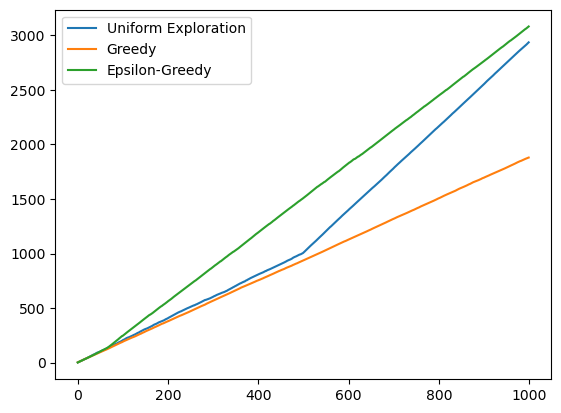

In [20]:
plt.plot(np.cumsum(ue_r_gauss_history), label="Uniform Exploration")
plt.plot(np.cumsum(gr_r_gauss_history), label="Greedy")
plt.plot(np.cumsum(eg_r_gauss_history), label="Epsilon-Greedy")
plt.legend()

In [21]:
A_

NameError: name 'A_' is not defined